In [ ]:
import json
import random
def filter_json(input_file_path, output_file_path, filter_values_c1):
    # 读取原始文件并过滤数据
    data_by_c3 = {}
    with open(input_file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            if data.get('c1') not in filter_values_c1 :
                c3_value = data.get('c3')
                if c3_value not in data_by_c3:
                    data_by_c3[c3_value] = []
                data_by_c3[c3_value].append(data)
    random.seed(114514)  # 设置固定的随机种子
    filtered_data = []
    for c3, items in data_by_c3.items():
        if len(items) > 20:
            filtered_data.extend(random.sample(items, 20))  # 从多余20个的商品中随机选20个
        else:
            filtered_data.extend(items)

    # 保存过滤后的数据到新文件
    with open(output_file_path, 'w') as file:
        for item in filtered_data:
            file.write(json.dumps(item) + '\n')
    # 保存过滤后的数据到新文件
    with open(output_file_path, 'w') as file:
        for item in filtered_data:
            file.write(json.dumps(item) + '\n')

filter_values_c1 = {'Herbs, Spices & Seasonings', 'Dried Beans, Grains & Rice', 'Relishes','Sauces, Gravies & Marinades'}

# 调用函数
filter_json('output.json', 'output_shrink.json', filter_values_c1)


In [ ]:
import json
import random
import re
import requests
def has_special_characters(string):
    pattern = r"[^\d$.]"
    if re.search(pattern, string):
        return True
    else:
        return False

def process_line(line):
    data = json.loads(line)
    if 'details' not in data or 'price' not in data or 'imageURLHighRes' not in data or 'description' not in data or 'category' not in data or 'title' not in data or len(data['category'])<4 or len(data['imageURLHighRes']) < 1 or len(data['description']) < 1 :
        return 0,False

    details_str = ' '.join([f"{k.strip()}: {v}" for k, v in data['details'].items()])
    # print(details_str)
    details_str = re.sub(r'ASIN:: \S+', '', details_str)
    details_str = re.sub(r'UPC:: \S+', '', details_str)
    details_str = re.sub(r'\s+', ' ', details_str).strip()

    # feature_str = ' '.join(data['feature'])
    # feature_str = re.sub(r'\s+', ' ', feature_str)
    if data['price']=="" or  has_special_characters(data['price']):
        data['price']=str(random.randint(1, 200))
    else:
        data['price']=data['price'].replace("$","")
    new_data = {
        'c1': data['category'][1],
        'c2': data['category'][2],
        'c3': data['category'][3],
        'name': data['title'],
        'info': data['description'][0],
        'detail': details_str,
        'img':data['imageURLHighRes'][0],
        'price':data['price']
    }
    return new_data,True

def process_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        test=0
        for line in infile:
            # if test>2:
            #     break
            new_line,ok = process_line(line)
            if ok==False:
                continue
            json.dump(new_line, outfile)
            outfile.write('\n')
            test+=1
            if(test%10000==0):
                print(f"now on {test}!")

# 用实际的文件路径替换以下占位符
input_file_path = 'meta_Grocery_and_Gourmet_Food.json/meta_Grocery_and_Gourmet_Food.json'
output_file_path = 'output.json'

process_file(input_file_path, output_file_path)


In [ ]:
def trans(text):
    try:
        with open('translations.txt', 'r', encoding='utf-8') as file:
            translations = file.readlines()
            for line in translations:
                original, translated = line.strip().split('||', 1)
                if text == original:
                    return translated
    except FileNotFoundError:
        pass
    # API调用进行翻译
    url = "https://api-free.deepl.com/v2/translate"
    payload = f'text={text}&target_lang=ZH'
    headers = {
      'Authorization': 'DeepL-Auth-Key 431e7c4b-e978-dd64-fd6f-40f4d687b736:fx',
      'Content-Type': 'application/x-www-form-urlencoded'
    }
    response = requests.request("POST", url, headers=headers, data=payload)
    data = json.loads(response.text)
    text_value = data['translations'][0]['text']
    # 保存新的翻译到本地文件
    with open('translations.txt', 'a', encoding='utf-8') as file:
        file.write(f'{text}||{text_value}\n')
    return text_value

def translate_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    translated_data = []
    i=0
    for line in lines:
        # if i<begin:
        #     continue
        # if i>=end:
        #     break
        i+=1
        if(i%1000==0):
            print(f"reached {i}!")
        data = json.loads(line)
        data['c1'] = trans(data['c1'])
        data['c2'] = trans(data['c2'])
        data['c3'] = trans(data['c3'])
        data['name'] = data['name']
        data['info'] = data['info']
        data['detail'] = data['detail']
        data['price'] = data['price']
        translated_data.append(data)

    with open(output_file, 'w', encoding='utf-8') as file:
        for item in translated_data:
            json.dump(item, file, ensure_ascii=False)
            file.write('\n')

# 调用函数
translate_file('output_shrink.json', 'output_trans.json')
# 287051

In [3]:
import json
import mysql.connector
import random

def connect_to_database():
    """连接到数据库并返回连接对象"""
    connection = mysql.connector.connect(
        host='127.0.0.1',
        user='root',
        password='root',
        database='mall'
    )
    return connection

def check_and_insert_category(connection, category_name, category_level, parent_id):
    """检查分类是否存在，并在不存在时插入"""
    category_name=category_name[:200]
    cursor = connection.cursor()
    query = "SELECT category_id FROM mall.mall_goods_category WHERE category_name = %s"
    cursor.execute(query, (category_name,))
    result = cursor.fetchone()

    if result:
        return result[0]
    else:
        insert_query = "INSERT INTO mall.mall_goods_category (category_name, category_level, parent_id) VALUES (%s, %s, %s)"
        cursor.execute(insert_query, (category_name, category_level, parent_id))
        connection.commit()
        return cursor.lastrowid

def process_line(connection, line):
    """处理每行JSON数据"""
    data = json.loads(line)
    # 插入分类
    category1_id = check_and_insert_category(connection, data['c1'], 1, 0)
    category2_id = check_and_insert_category(connection, data['c2'], 2, category1_id)
    category3_id = check_and_insert_category(connection, data['c3'], 3, category2_id)

    # 插入商品信息
    insert_goods_query = """
    INSERT INTO mall.mall_goods_info
    (goods_name, goods_intro, goods_category_id, goods_cover_img,goods_detail_content, original_price, selling_price)
    VALUES (%s, %s, %s, %s, %s, %s,%s)
    """
    cursor = connection.cursor()

    cursor.execute(insert_goods_query, (
        data['name'][:1000],
        data['info'][:1000],
        category3_id,
        data['img'][:500],
        data['detail'],
        float(data['price']),
        float(data['price'])
    ))
    connection.commit()

def process_file(input_file_path):
    connection = connect_to_database()
    with open(input_file_path, 'r', encoding='utf-8') as infile:
        i=0
        for line in infile:
            process_line(connection, line)
            i+=1
            # if i>1000:
                # break
            if i%1000==0:
                print(f"reached {i}")
    connection.close()

input_file_path = 'output_trans_reprice.json'
process_file(input_file_path)


reached 1000
reached 2000
reached 3000
reached 4000
reached 5000
reached 6000
reached 7000


In [ ]:
connection = connect_to_database()
cursor = connection.cursor()
query = "SELECT goods_id, goods_name, goods_intro, goods_detail_content FROM tb_newbee_mall_goods_info"
cursor.execute(query)

with open('embedding.txt', 'w', encoding='utf-8') as file:
    for goods_id, goods_name, goods_intro, goods_detail_content in cursor:
        combined_string = f"{goods_id}:{goods_name} {goods_intro} {goods_detail_content}"
        cleaned_string = combined_string.replace('\n', '')
        file.write(cleaned_string + '\n')
connection.close()

In [ ]:
!pip install langchain openai

In [1]:
from langchain.embeddings import OpenAIEmbeddings
from tqdm import tqdm
embeddings=OpenAIEmbeddings(
    openai_api_base= "https://api.kwwai.top/v1",
    openai_api_key="sk-B0KbmtufXU180pSQ2282292cE4Fe487e875aB1440c28Ef83",
)

# vector_test=embeddings.embed_query('test embeddings')
# display(vector_test[:5],len(vector_test))
def process_line(line):
    parts = line.split(':', 1)
    id = parts[0]
    text = parts[1].strip()
    vector = embeddings.embed_query(text)
    return id, vector

processed_ids = set()
try:
    with open('embedding_res.txt', 'r', encoding='utf-8') as res_file:
        for res_line in res_file:
            processed_id = res_line.split(':')[0]
            processed_ids.add(processed_id)
except FileNotFoundError:
    pass
total_lines = sum(1 for line in open('embedding.txt', 'r', encoding='utf-8'))
with open('embedding.txt', 'r', encoding='utf-8') as infile:
    for line in tqdm(infile, total=total_lines, desc="Processing"):
        id =  line.split(':')[0]
        if id not in processed_ids:
            _, vector = process_line(line)
            with open('embedding_res.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(f"{id}:{vector}\n")

C:\Users\NP_123\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
Processing: 100%|██████████| 7506/7506 [1:06:54<00:00,  1.87it/s]


In [43]:
from langchain.vectorstores.pgvector import PGVector
import numpy as np
import psycopg2

host = "localhost"
dbname = "vector_db"
user = "postgres"
password = "root"
conn = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host
)
cursor = conn.cursor()
insert_query = "INSERT INTO vectors (id, embedding) VALUES (%s, %s);"
with open('embedding_res.txt', 'r', encoding='utf-8') as input_file:
    i=0
    for line in input_file:
        id_str, vector_str = line.strip().split(':', 1)
        # vector_str = vector_str.strip('[]')
        # vector_list = vector_str.split(',')
        # display(id_str,vector[:5])
        # vector = [float(x) for x in vector_list]
        cursor.execute(insert_query,(int(id_str) ,vector_str))
        conn.commit()
        i+=1
        if i%1000==0:
            print(f"reached {i}!")

cursor.close()
conn.close()

reached 1000!
reached 2000!
reached 3000!
reached 4000!
reached 5000!
reached 6000!
reached 7000!


In [85]:
test_query="0:high energy"
_,tar_vector = process_line(test_query)
similar_query = "SELECT id FROM vectors ORDER BY (embedding <-> %s) LIMIT 5;"
conn = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host
)
cursor = conn.cursor()
cursor.execute(similar_query,(str(tar_vector),))
results=cursor.fetchall()
conn.close()
results

[(1426,), (1423,), (1425,), (4481,), (1431,)]

In [92]:
import numpy as np
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA


def get_category_name(cursor, goods_id):
    query = '''select category_name,category_id from tb_newbee_mall_goods_category where category_id=
                 (select parent_id from tb_newbee_mall_goods_category where category_id=
                    (select parent_id from tb_newbee_mall_goods_category where category_id=
                      (select goods_category_id from tb_newbee_mall_goods_info where goods_id= %s )))'''
    cursor.execute(query, (goods_id,))
    result = cursor.fetchone()
    return result[0] if result else None

connection = connect_to_database()
cursor = connection.cursor()

vectors = []
ids = []

with open('embedding_res.txt', 'r', encoding='utf-8') as input_file:
    for line in input_file:
        id_str, vector_str = line.strip().split(':', 1)
        vector = np.fromstring(vector_str[1:-1], sep=',')  # 去除方括号并转换为 numpy 数组
        vectors.append(vector)
        ids.append(id_str)

n_clusters = 20  # 一共有20个一级品类
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(vectors)

category_names = [get_category_name(cursor, id_str) for id_str in ids]
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

C:\Users\NP_123\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


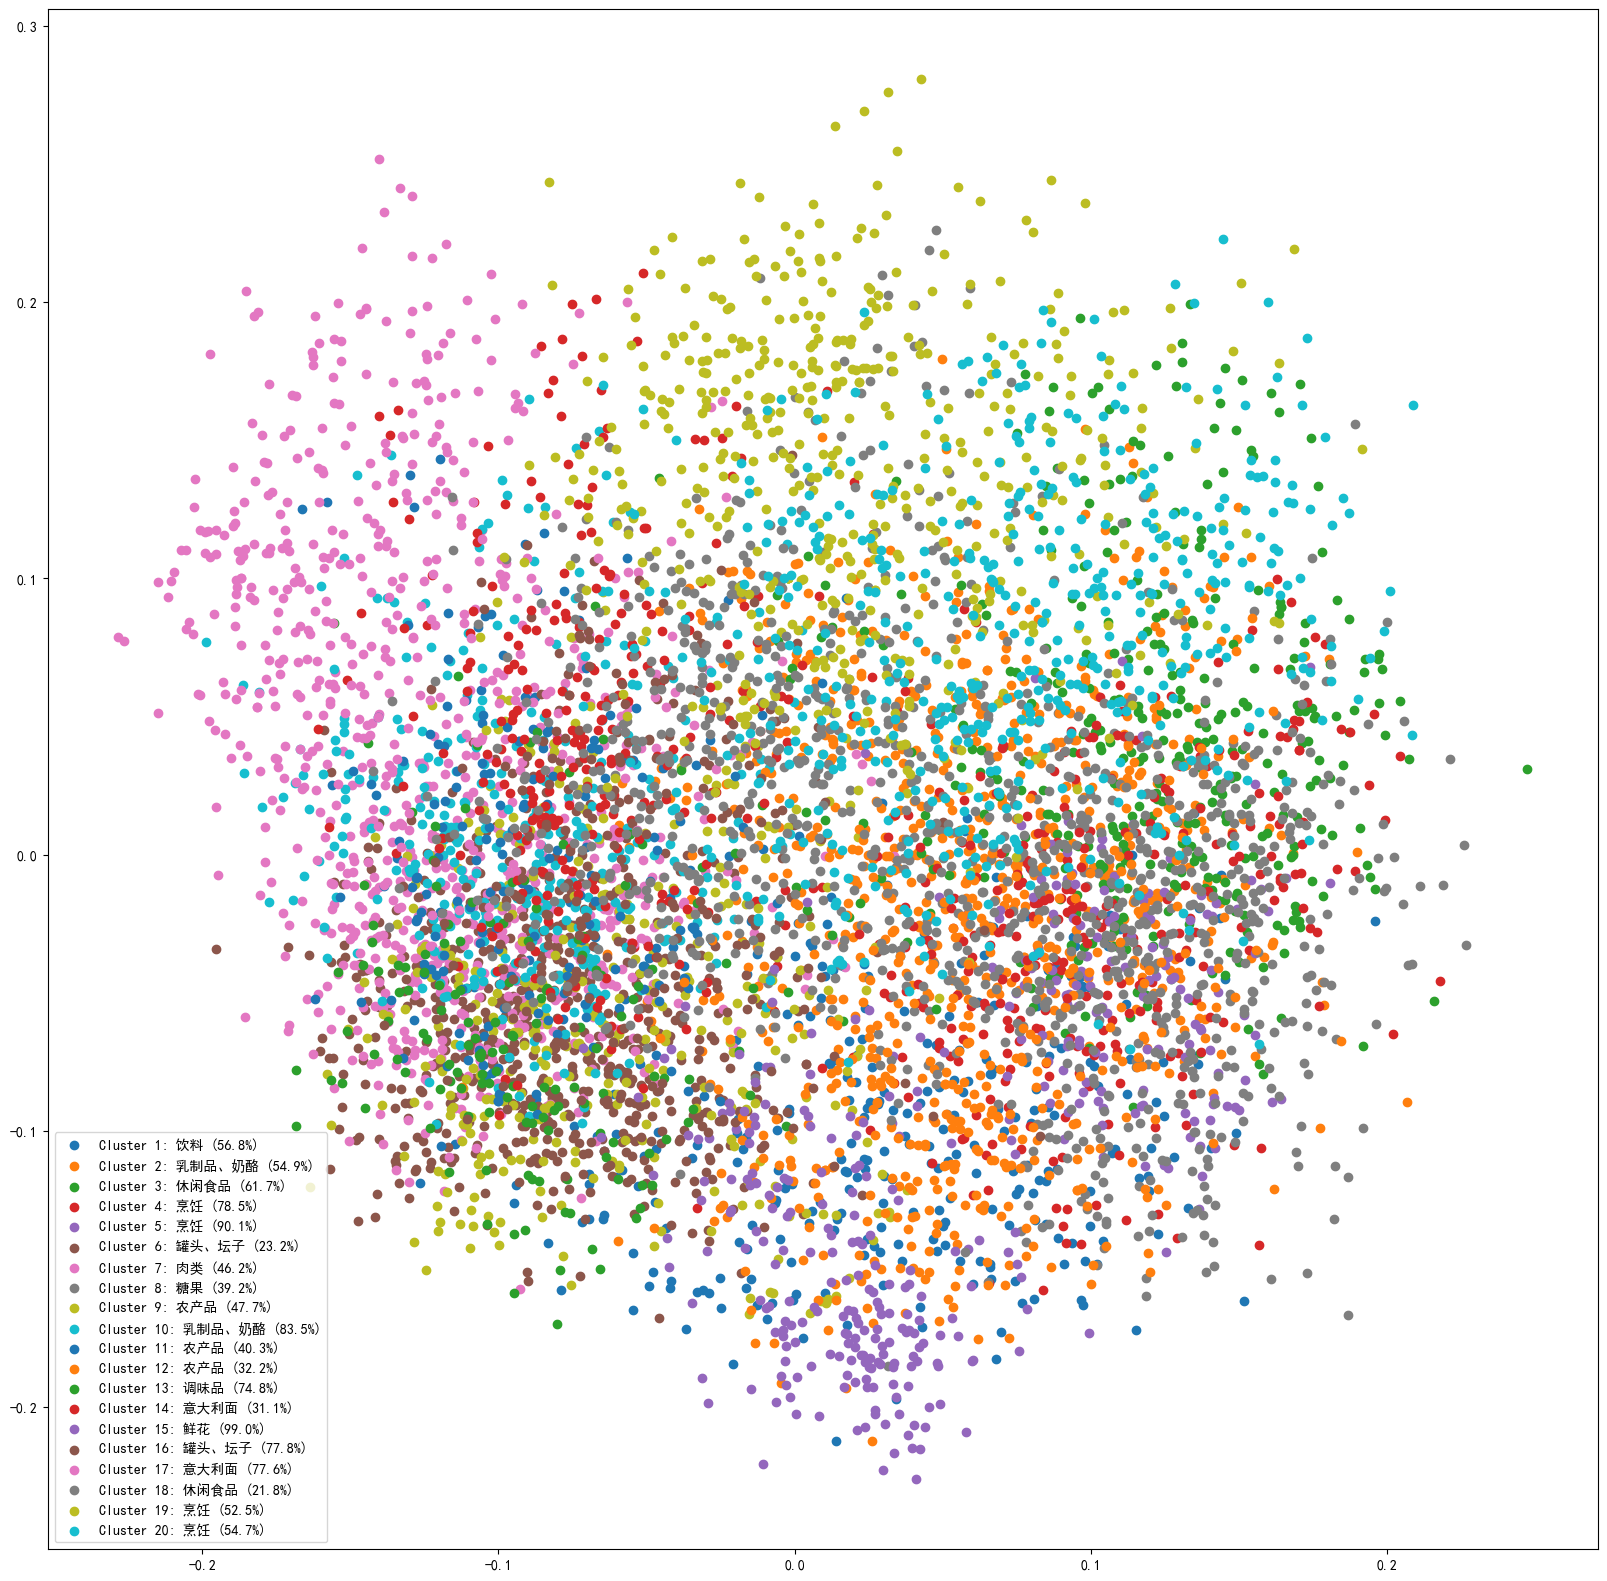

Cluster 0:
  Size: 303
  Top 3 Categories:
    饮料: 172 (56.8%)
    酒精饮料: 83 (27.4%)
    烹饪: 22 (7.3%)
    农产品: 8 (2.6%)

Cluster 1:
  Size: 503
  Top 3 Categories:
    乳制品、奶酪: 276 (54.9%)
    饮料: 97 (19.3%)
    烹饪: 45 (8.9%)
    冷冻: 37 (7.4%)

Cluster 2:
  Size: 373
  Top 3 Categories:
    休闲食品: 230 (61.7%)
    None: 64 (17.2%)
    烹饪: 46 (12.3%)
    曲奇: 12 (3.2%)

Cluster 3:
  Size: 293
  Top 3 Categories:
    烹饪: 230 (78.5%)
    None: 24 (8.2%)
    饮料: 23 (7.8%)
    糖果: 4 (1.4%)

Cluster 4:
  Size: 171
  Top 3 Categories:
    烹饪: 154 (90.1%)
    糖果: 6 (3.5%)
    None: 5 (2.9%)
    面条: 2 (1.2%)

Cluster 5:
  Size: 578
  Top 3 Categories:
    罐头、坛子: 134 (23.2%)
    橄榄、腌菜: 118 (20.4%)
    调味品: 103 (17.8%)
    农产品: 48 (8.3%)

Cluster 6:
  Size: 530
  Top 3 Categories:
    肉类: 245 (46.2%)
    None: 100 (18.9%)
    布永: 91 (17.2%)
    熟食: 35 (6.6%)

Cluster 7:
  Size: 587
  Top 3 Categories:
    糖果: 230 (39.2%)
    None: 172 (29.3%)
    休闲食品: 59 (10.1%)
    烹饪: 41 (7.0%)

Cluster 8:
  Size:

In [102]:
import matplotlib.pyplot as plt
from collections import Counter
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.figure(figsize=(20, 20))
for i in range(n_clusters):
    # 绘制每个聚类
    cluster_indices = labels == i
    cluster_vectors = reduced_vectors[cluster_indices]
    cluster_category_names = [category_names[j] for j in range(len(category_names)) if cluster_indices[j]]

    # 计算最常见的类别及其比例
    category_counts = Counter(cluster_category_names)
    most_common_category, count = category_counts.most_common(1)[0]
    proportion = count / len(cluster_category_names) * 100

    # 创建图例标签
    legend_label = f'Cluster {i+1}: {most_common_category} ({proportion:.1f}%)'

    x = cluster_vectors[:, 0]
    y = cluster_vectors[:, 1]
    plt.scatter(x, y, label=legend_label)

plt.legend()
plt.show()
for i in range(n_clusters):
    cluster_indices = labels == i
    cluster_size = sum(cluster_indices)
    cluster_category_names = [category_names[j] for j in range(len(category_names)) if cluster_indices[j]]

    category_counts = Counter(cluster_category_names)
    most_common_categories = category_counts.most_common(4)  # 获取最常见的三个类别

    # 打印信息
    print(f"Cluster {i}:")
    print(f"  Size: {cluster_size}")
    print(f"  Top 3 Categories:")
    for category, count in most_common_categories:
        proportion = count / cluster_size * 100
        print(f"    {category}: {count} ({proportion:.1f}%)")
    print()




28.38283828382838 饮料
27.435387673956264 乳制品、奶酪
30.831099195710454 休闲食品
39.249146757679185 烹饪
45.02923976608187 烹饪
11.591695501730104 罐头、坛子
23.11320754716981 肉类
19.591141396933562 糖果
23.8544474393531 农产品
41.733333333333334 乳制品、奶酪
20.153061224489797 农产品
16.10978520286396 农产品
37.41935483870968 调味品
15.551839464882944 意大利面
49.504950495049506 鲜花
38.88888888888889 罐头、坛子
38.812154696132595 意大利面
10.899653979238755 休闲食品
26.24750499001996 烹饪
27.327935222672068 烹饪
70.46204620462046 酒精饮料
64.51292246520875 饮料
70.24128686327077 None
82.59385665529011 None
91.81286549707602 糖果
33.391003460207614 橄榄、腌菜
55.660377358490564 None
53.83304940374787 None
60.78167115902965 罐头、坛子
85.60000000000001 None
53.8265306122449 罐头、坛子
46.18138424821002 罐头、坛子
80.3225806451613 肉类
42.80936454849498 罐头、坛子
99.25742574257426 饮料
82.40740740740742 农产品
81.90607734806629 None
31.920415224913498 曲奇
57.884231536926144 None
60.02024291497976 果酱、果冻
87.78877887788778 烹饪
78.62823061630219 烹饪
84.98659517426273 烹饪
90.61433447098977 饮料
95

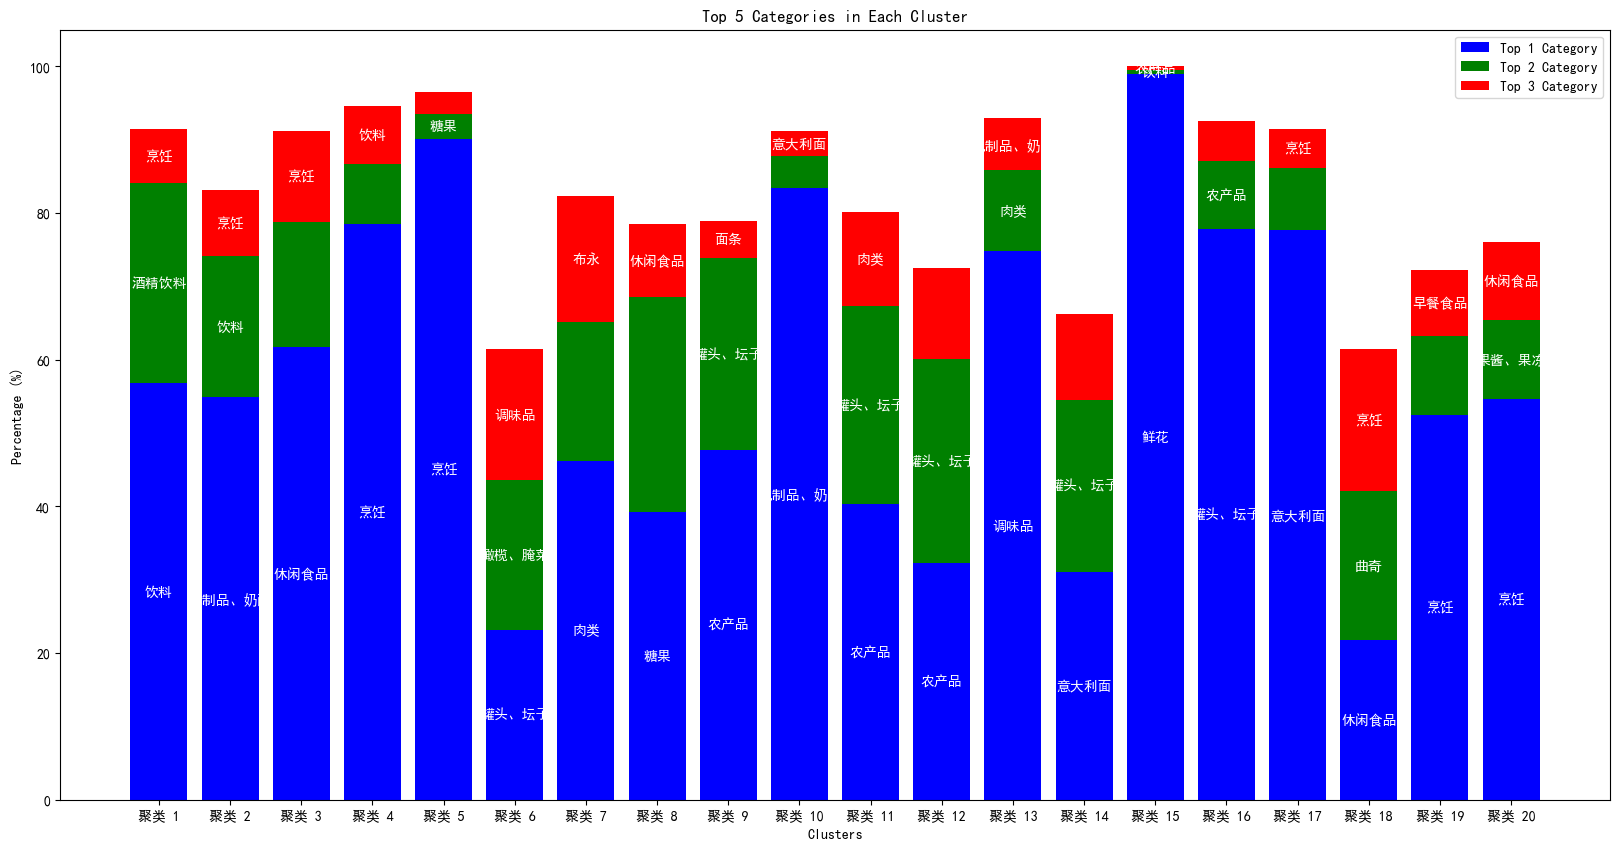

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# 初始化数据存储结构
category_data = {i: [] for i in range(n_clusters)}
proportion_data = {i: [] for i in range(n_clusters)}

# 收集每个聚类的数据
for i in range(n_clusters):
    cluster_indices = labels == i
    cluster_size = sum(cluster_indices)
    cluster_category_names = [category_names[j] for j in range(len(category_names)) if cluster_indices[j]]
    category_counts = Counter(cluster_category_names)
    most_common_categories = category_counts.most_common(5)

    for category, count in most_common_categories:
        category_data[i].append(category)
        proportion_data[i].append(count / cluster_size * 100)

# 绘制堆叠条形图
plt.figure(figsize=(20, 10))
bottom = np.zeros(n_clusters)

colors = ['blue', 'green', 'red']  # 每个品类的颜色

for i in range(3):
    proportions = [proportion_data[j][i] for j in range(n_clusters) if len(proportion_data[j]) > i]
    plt.bar(range(n_clusters), proportions, bottom=bottom, color=colors[i], label=f'Top {i+1} Category')
    # 在每个柱子上添加品类标注
    for j in range(n_clusters):
        if i < len(category_data[j]):
            height = bottom[j] + proportions[j] / 2
            print(height, category_data[j][i])
            plt.text(j, height, category_data[j][i], ha='center', va='center', color='white')

    # 更新 bottom，为下一个堆叠做准备
    bottom += np.array(proportions)

plt.xlabel('Clusters')
plt.ylabel('Percentage (%)')
plt.title('Top 5 Categories in Each Cluster')
plt.xticks(range(n_clusters), [f'聚类 {i+1}' for i in range(n_clusters)])
plt.legend()
plt.show()